In [11]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

In [12]:
# Define necessary functions (placeholders)
#Hodgkin Huxley
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# Calcium in HH
def m_inf(V):
  return 1 / (1 + np.exp(-(V + 20)/9))

# Model Stimulus
def stim(t):
  if int(t)%125 == 0 :#(100 < t < 105) or (25 < t < 30):
    return 1000
  return 0

In [13]:
class ModelSystem:
    def __init__(self, params, stim):
        self.params = params
        self.stim = stim
    def computeDeriv(self, state, t):
        Glu_syn, r_AMPA, r_NMDA, Ca_ast, DAG, DIM, IP3, PKC, R_i, Vm, n, m, h, Ca_neuron = state
        modelPar = self.params

        # Intermediate variables
        # Glutamate
        Glu_ast = modelPar.k_ast*Glu_syn
        Glu_post = modelPar.k_post*Glu_syn

        # Astrocyte
        R_2 = modelPar.K_aff * DIM / (math.ceil(Glu_ast) ** 2)
        DIMp = (modelPar.R_tot - math.sqrt(modelPar.K_di * R_2) - 2 * R_2 - 2 * DIM) / 2
        IR_a = (1 - R_i) * IP3 ** 2 / (IP3 ** 2 + modelPar.K_I ** 2) * Ca_ast ** 3 / (Ca_ast ** 3 + modelPar.K_act ** 3)

        # Hodgkin Huxley
        I_Na = modelPar.g_Na * m**3 * h * (Vm - modelPar.E_Na)
        I_K = modelPar.g_K * n**4 * (Vm - modelPar.E_K)
        I_L = modelPar.g_L * (Vm - modelPar.E_L)
        I_AMPA_Na = modelPar.g_AMPA * r_AMPA * (Vm - modelPar.E_Na)
        I_AMPA_K = modelPar.g_AMPA * r_AMPA * (Vm - modelPar.E_K)
        I_NMDA_Na = (modelPar.g_NMDA*r_NMDA*(Vm - modelPar.E_Na)) / (1 + 0.33*modelPar.Mg2*math.exp(-0.07*Vm - 0.7))
        I_NMDA_K = (modelPar.g_NMDA*r_NMDA*(Vm - modelPar.E_K)) / (1 + 0.33*modelPar.Mg2*math.exp(-0.07*Vm - 0.7))
        I_Ca = modelPar.g_Ca * m_inf(Vm)**2 * (Vm - modelPar.E_Ca)

        # dx/dt
        # Glutamate
        dGlu_syn_per_dt = - Glu_ast - Glu_post + stim(t)
        dr_AMPA_per_dt = Glu_post*modelPar.a_AMPA*(1-r_AMPA) - modelPar.b_AMPA*r_AMPA
        dr_NMDA_per_dt = Glu_post*modelPar.a_NMDA*(1-r_NMDA) - modelPar.b_NMDA*r_NMDA
        # Astrocyte
        dCa_ast_per_dt = modelPar.v_0 + (modelPar.b_1k_i + modelPar.k_i * IR_a) * (modelPar.Ca_tot - (modelPar.alpha + 1) * Ca_ast) - modelPar.V_MP * Ca_ast ** 2 / (Ca_ast ** 2 + modelPar.K_P ** 2) - modelPar.k_l * Ca_ast
        dDAG_per_dt = modelPar.k_PLC * DIM - modelPar.V_MD * DAG / (DAG + modelPar.K_MD)
        dDIM_per_dt = modelPar.V_M1 * DIMp / (DIMp + modelPar.K_A1) - modelPar.V_PKC * PKC * DIM / (DIM + modelPar.K_A)
        dIP3_per_dt = modelPar.k_PLC * DIM - modelPar.k_1 * IP3
        dPKC_per_dt = modelPar.k_act * DAG / (DAG + modelPar.K_AD) * (1 - PKC) - modelPar.k_des * PKC
        dR_i_per_dt = modelPar.k_iplus * Ca_ast ** 4 * (1 - R_i) * modelPar.K_act ** 3 / (modelPar.K_act ** 3 + Ca_ast ** 3) - modelPar.k_iminus * R_i

        # Hodgkin Huxley
        #dVm_per_dt = (I_post(modelPar.k_post*Glu_syn) - I_Na - I_K - I_L - I_Ca) / modelPar.C_m
        dVm_per_dt = -(I_AMPA_Na + I_AMPA_K + I_NMDA_Na + I_NMDA_K + I_Na + I_K + I_L + I_Ca) / modelPar.C_m
        dm_per_dt = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
        dh_per_dt = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
        dn_per_dt = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
        # Calcium in HH
        dCa_neuron_per_dt = - (modelPar.a_Ca*I_Ca) - (Ca_neuron/modelPar.t_Ca)

        deriv = [dGlu_syn_per_dt, dr_AMPA_per_dt, dr_NMDA_per_dt, dCa_ast_per_dt, dDAG_per_dt, dDIM_per_dt, dIP3_per_dt, dPKC_per_dt, dR_i_per_dt, dVm_per_dt, dn_per_dt, dm_per_dt, dh_per_dt, dCa_neuron_per_dt]

        return deriv

In [14]:
class ModelParameters:
    # Glutamate
    k_ast = 0.08
    k_post = 0.02
    N_syn = 20
    g_factor = 0.25
    g_NMDA = (8.5/N_syn)*g_factor
    g_AMPA = (18.75/N_syn)*g_factor
    a_AMPA = 1.1 #1/mM*ms
    a_NMDA = 0.072 #1/mM*ms
    b_AMPA = 0.19 #1/ms
    b_NMDA = 0.0066 #1/ms
    Mg2 = 1.2 #mM

    # Astrocyte
    alpha = 0.1       # 1, This parameter added from Dupont 1997, 2000, needed because Ca equation was modified
    b_1k_i = 7.5e-4   # uM/s
    Ca_tot = 80       # uM, This parameter added from Dupont 1997, 2000, needed because Ca equation was modified
    k_1 = 0.12        # 1/s
    K_A = 5e-4        # uM
    K_A1 = 5e-4       # uM
    k_act = 0.2       # 1/s
    K_act =  0.34     # uM
    K_AD = 0.06       # uM
    K_aff = 2         # uM^2
    k_des = 0.2       # 1/s
    K_di = 0.1        # uM
    k_i = 7.5         # uM/s
    K_I = 0.4         # uM
    k_iplus = 25      # 1/(um^4 s)
    k_iminus = 0.0025 # 1/s
    k_l = 0.0025      # 1/s
    K_MD = 0.012      # uM
    K_P = 0.4         # uM
    k_PLC = 1.25      # 1/s
    R_tot = 0.075     # uM
    v_0 = 0.025       # uM/s
    V_M1 = 0.05       # uM/s
    V_MD = 0.0325     # uM/s
    V_MP = 2          # uM/s
    V_PKC = 0.2       # uM/s

    # Hodgkin Huxley
    C_m = 1.0  # Membrane capacitance, in uF/cm^2
    g_Na = 120.0  # Maximum conductance of Na channels, in mS/cm^2
    g_K = 36.0  # Maximum conductance of K channels, in mS/cm^2
    g_L = 0.2 # Original 0.3  # Conductance of leak channels, in mS/cm^2
    E_Na = 55.0  # Sodium equilibrium potential, in mV
    E_K = -90.0  # Potassium equilibrium potential, in mV
    E_L = -54.387  # Leak equilibrium potential, in mV
    # Ca in HH
    g_Ca = 1.5 # 0.4 # Average calcium channel conductance per unit area (mS/cm^2)
    E_Ca = 134.0 # Calcium potential (mV)
    a_Ca = 0.000667 # µM(ms µA)e-1 cm2
    t_Ca = 80 # ms

    '''ALS changed parameters
    gK = 24.0
    gNa = 80.0
    gL = 0.5'''


In [15]:
To = 0
Tmax = 500
dt = 0.1
t = np.arange(To, Tmax, dt)

Glu_syn = 0.0001
r_AMPA = 0.0001
r_NMDA = 0.0001
Ca_ast = 0.1
DAG = 25e-3
DIM = 14e-3
IP3 = 0.2
PKC = 0.2
R_i = 0.9898
Vm = -65  # Initial membrane potential, in mV
m = 0.05  # Initial m-gate value
h = 0.6  # Initial h-gate value
n = 0.32  # Initial n-gate value
Ca_neuron = 0.2
initial = [Glu_syn, r_AMPA, r_NMDA, Ca_ast, DAG, DIM, IP3, PKC, R_i, Vm, n, m, h, Ca_neuron]

# Instantiate model parameters and system
params = ModelParameters()
mySys_1 = ModelSystem(params, stim)

# Solve the system of ODEs
model_data = odeint(mySys_1.computeDeriv, initial, t)

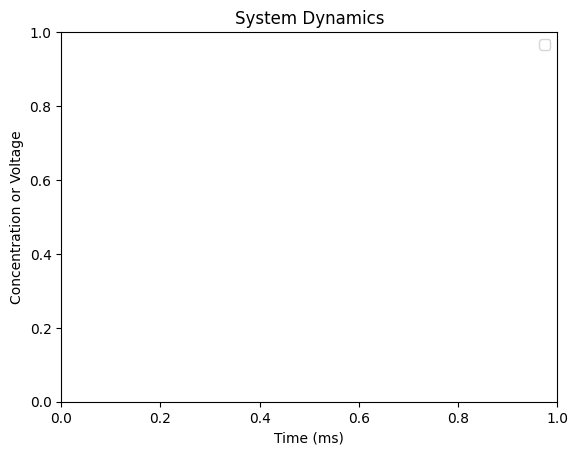

In [16]:
# Plot results
#plt.figure(figsize=(12, 8))
#plt.plot(t, model_data[:, 0]*0.02*3, label='Glu_syn')
#plt.plot(t, model_data[:, 1], label='r_AMPA')
#plt.plot(t, model_data[:, 2], label='r_NMDA')
#plt.plot(t, model_data[:, 3], label='Ca_ast')
#plt.plot(t, model_data[:, 4], label='DAG')
#plt.plot(t, model_data[:, 5], label='DIM')
#plt.plot(t, model_data[:, 6], label='IP3')
#plt.plot(t, model_data[:, 7], label='PKC')
#plt.plot(t, model_data[:, 8], label='R_i')
#plt.plot(t, model_data[:, 9], label='Vm')
#plt.plot(t, model_data[:, 10], label='n')
#plt.plot(t, model_data[:, 11], label='m')
#plt.plot(t, model_data[:, 12], label='h')
#plt.plot(t, model_data[:, 13], label='Ca_neuron')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Concentration or Voltage')
plt.title('System Dynamics')
plt.show()

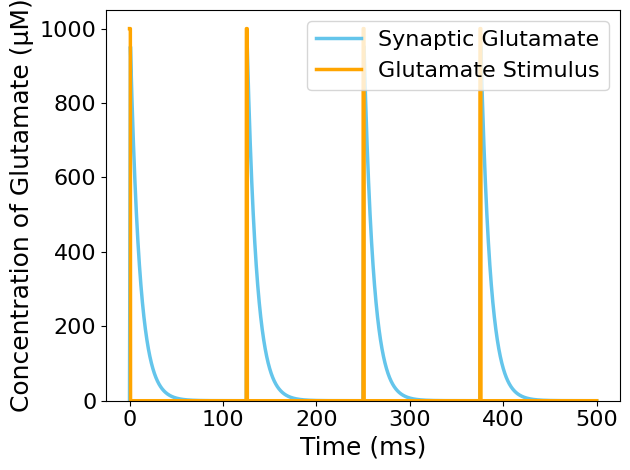

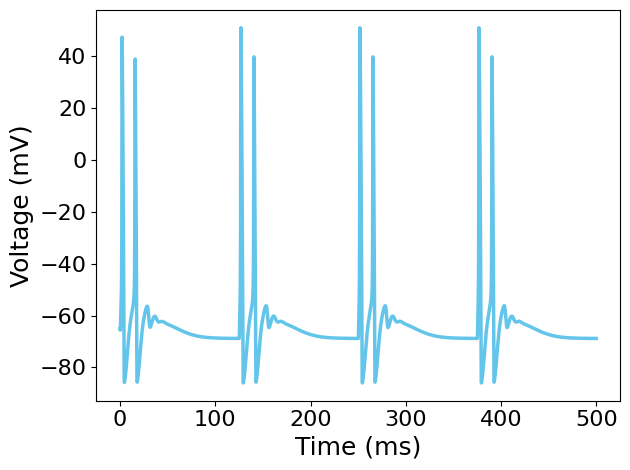

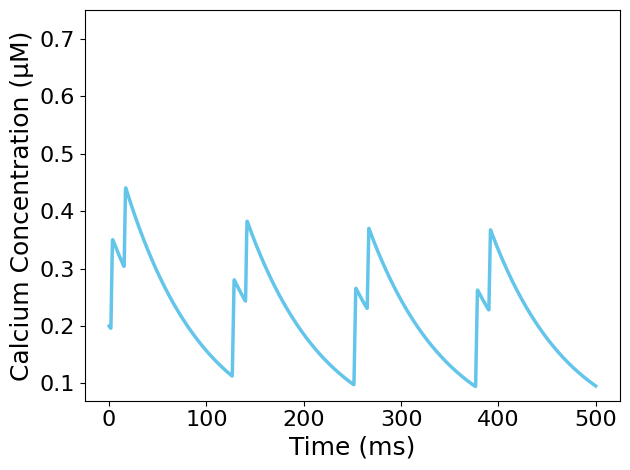

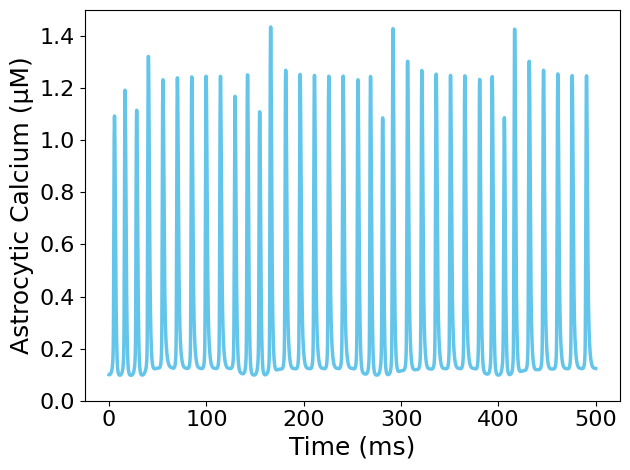

In [17]:
import matplotlib.pyplot as plt

# Define font sizes
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 16
tick_fontsize = 16

# Define line width
line_width = 2.5

# Plot 1: Vm over time
plt.plot(t, model_data[:, 0], label='Synaptic Glutamate', color='#64C5EB', linewidth=line_width)
plt.plot(t, [stim(i) for i in t], label='Glutamate Stimulus', color='orange', linewidth=line_width)
plt.legend(fontsize=legend_fontsize)
plt.xlabel('Time (ms)', fontsize=label_fontsize)
plt.ylabel('Concentration of Glutamate (µM)', fontsize=label_fontsize)
plt.ylim([0, 1050])
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

# Plot 2: Glu_syn and r_AMPA over time
plt.plot(t, model_data[:, 9], label='Vm', color='#64C5EB', linewidth=line_width)
plt.xlabel('Time (ms)', fontsize=label_fontsize)
plt.ylabel('Voltage (mV)', fontsize=label_fontsize)
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

# Plot 3: Ca_neuron over time
plt.plot(t, model_data[:, 13], label='Postsynaptic Neuronal Calcium', color='#64C5EB', linewidth=line_width)
plt.xlabel('Time (ms)', fontsize=label_fontsize)
plt.ylabel('Calcium Concentration (µM)', fontsize=label_fontsize)
plt.ylim([0.07, 0.75])
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

# Plot 4: Ca_ast over time
plt.plot(t, model_data[:, 3], label='Ca_ast', color='#64C5EB', linewidth=line_width)
plt.xlabel('Time (ms)', fontsize=label_fontsize)
plt.ylabel('Astrocytic Calcium (µM)', fontsize=label_fontsize)
plt.ylim([0, 1.5])
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

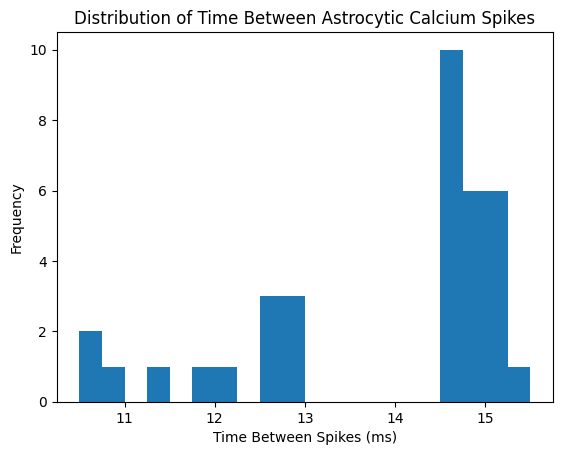

[1.0932704028291942, 1.1920829508353643, 1.1151633197828672, 1.3217297430099786, 1.2321673103018935, 1.2395374922490514, 1.2431834199558955, 1.2454707326085823, 1.2452835575943448, 1.1685153368743517, 1.2510615116875248, 1.109213945139374, 1.4347307766328792, 1.2686182780385344, 1.2525049251066296, 1.248929449668682, 1.2457366883920133, 1.246264902905015, 1.2320971032884331, 1.2446267762732632, 1.0858572842835001, 1.4282509530468444, 1.303158732395012, 1.2677644773685193, 1.2537360607143977, 1.248880396802629, 1.2472477226077912, 1.233517565177643, 1.2440377107778955, 1.0865139582938117, 1.42637194396154, 1.303236781782241, 1.2685291846201567, 1.2546729390345654, 1.2482569701245467, 1.2472179884534997]
0.2, 0.1997509949202511, 0.19950224293341917, 0.19925383777902303, 0.19900588754500548, 0.19875850654895444, 0.1985118118189978, 0.1982659239288915, 0.19802097605270239, 0.19777713192989366, 0.19753461475357473, 0.1972937567670565, 0.19705509421145653, 0.19681957525320182, 0.196589073536

In [18]:
cal = model_data[:, 3]
spike_indices = [i for i in range(1, len(cal) - 1) if cal[i - 1] < cal[i] > cal[i + 1]]
time_between_spikes = [(spike_indices[i + 1] - spike_indices[i]) * 0.1 for i in range(len(spike_indices) - 1)]

plt.hist(time_between_spikes, bins=20)
plt.title('Distribution of Time Between Astrocytic Calcium Spikes')
plt.xlabel('Time Between Spikes (ms)')
plt.ylabel('Frequency')
plt.show()

print([cal[int(i)] for i in spike_indices])

for i in model_data[:, 13]:
  print(str(i) + ", ", end="")

print("")
for i in model_data[:, 0]:
  print(str(i) + ", ", end="")

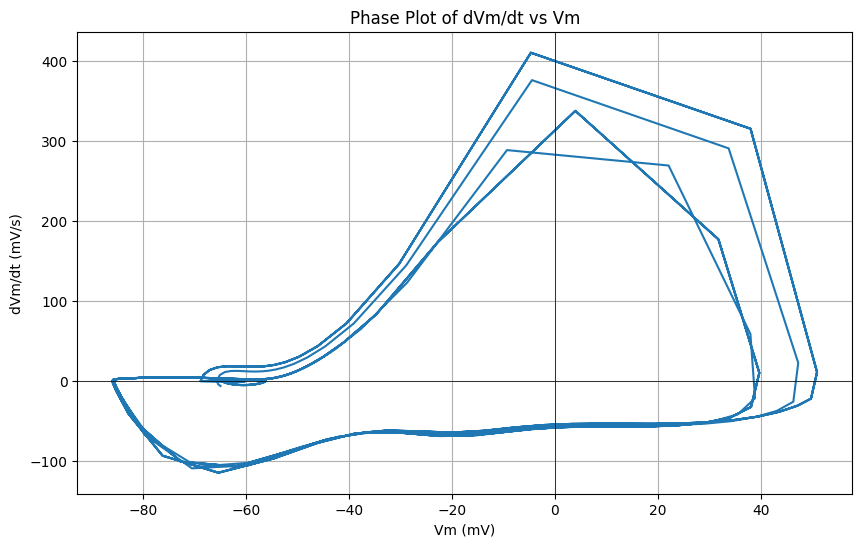

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract Vm and dVm/dt from model_data
Vm = model_data[:, 9]
dVm_dt = np.array([mySys_1.computeDeriv(state, time)[9] for state, time in zip(model_data, t)])

# Plot dVm/dt vs Vm
plt.figure(figsize=(10, 6))
plt.plot(Vm, dVm_dt, label='dVm/dt vs Vm')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Vm (mV)')
plt.ylabel('dVm/dt (mV/s)')
plt.title('Phase Plot of dVm/dt vs Vm')
plt.grid(True)
plt.show()

In [10]:
!pip install plotly
import numpy as np
import plotly.graph_objects as go

# Compute the derivatives for plotting
dGlu_syn_dt = np.array([mySys_1.computeDeriv(state, time)[0] for state, time in zip(model_data, t)])
dCa_neuron_dt = np.array([mySys_1.computeDeriv(state, time)[13] for state, time in zip(model_data, t)])
dVm_dt = np.array([mySys_1.computeDeriv(state, time)[10] for state, time in zip(model_data, t)])

# Find indices where dGlu_syn_dt > 200
valid_indices = dGlu_syn_dt <= 200

# Filter out those points from all arrays
filtered_dGlu_syn_dt = dGlu_syn_dt[valid_indices]
filtered_dCa_neuron_dt = dCa_neuron_dt[valid_indices]
filtered_dVm_dt = dVm_dt[valid_indices]

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=filtered_dGlu_syn_dt,
    y=filtered_dCa_neuron_dt,
    z=filtered_dVm_dt,
    mode='markers',
    marker=dict(
        size=3,
        color=filtered_dVm_dt,
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    title='Interactive 3D Plot of dVm/dt vs dGlu_syn_dt vs dCa_neuron_dt',
    scene=dict(
        xaxis_title='dGlu_syn_dt',
        yaxis_title='dCa_neuron_dt',
        zaxis_title='dVm/dt (mV/s)'
    )
)

fig.show()